In [26]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os,IPython, librosa, mir_eval
from os import listdir
from os.path import isfile, join,isdir
from IPython.display import Audio
from librosa.display import waveplot,specshow
from librosa.onset import onset_strength, onset_detect
from librosa.feature import melspectrogram, mfcc
from librosa import load

from collections import defaultdict,OrderedDict
import sklearn
from sklearn.preprocessing import StandardScaler,LabelEncoder
import scipy
from pandas import HDFStore,DataFrame



In [27]:
song, sampling_rate = librosa.load("/Users/chibmac/Documents/fma_small/Electronic/99289.mp3")


In [28]:
song_length = song.shape[0]
song_length

661248

In [29]:
num_of_sections = 24
song_length/num_of_sections

27552.0

In [30]:
#+1 so the last index is included
song_splitter = np.arange(0,song_length+1,song_length/num_of_sections,dtype=int)
song_splitter

array([     0,  27552,  55104,  82656, 110208, 137760, 165312, 192864,
       220416, 247968, 275520, 303072, 330624, 358176, 385728, 413280,
       440832, 468384, 495936, 523488, 551040, 578592, 606144, 633696,
       661248])

In [31]:
unit_song = song[song_splitter[0]:song_splitter[1]]
unit_song_length = unit_song.shape[0]
unit_song_length

27552

In [32]:
num_of_mfcc = 12

complete_split = num_of_sections *num_of_mfcc
complete_split

288

In [33]:
window_width = np.int(unit_song_length/num_of_sections)+1

In [34]:
unit_mfcc = librosa.feature.mfcc(y=unit_song, sr=sampling_rate,n_mfcc=num_of_mfcc,hop_length = window_width).T

unit_mfcc.shape

(24, 12)

In [35]:
unit_song.shape

(27552,)

In [36]:
split_song = np.reshape(unit_song,(num_of_sections,int(unit_song_length/num_of_sections)))
split_song.shape

(24, 1148)

In [37]:
unit_zcr = np.sum(librosa.core.zero_crossings(split_song),axis =1)
unit_zcr

array([ 83,  34,  34,  35,  65,  92, 131,  78,  50,  75,  79,  93,  44,
        63,  67, 118, 101,  67,  31,  49,  72,  55,  82,  39])

In [38]:
unit_zcr.shape

(24,)

In [39]:
ind_unit_features=np.concatenate((unit_mfcc,np.array([unit_zcr]).T),axis=1)
ind_unit_features.shape

(24, 13)

In [40]:
def complete_extract_features(song,num_of_sections,num_of_mfcc,genre):  
    complete_split = num_of_sections *num_of_mfcc
    song_splitter = np.arange(0,song_length+1,song_length/num_of_sections,dtype=int)
    genres = np.ones(num_of_sections,dtype=int) * genre
    for i in range(len(song_splitter)):
        unit_song = song[song_splitter[i]:song_splitter[i+1]]
        unit_song_length = unit_song.shape[0]
        window_width = np.int(unit_song_length/num_of_sections)+1
        unit_mfcc = librosa.feature.mfcc(y=unit_song, sr=sampling_rate,n_mfcc=num_of_mfcc,hop_length = window_width).T
        split_song = np.reshape(unit_song,(num_of_sections,int(unit_song_length/num_of_sections)))
        unit_zcr = np.sum(librosa.core.zero_crossings(split_song),axis =1)
        ind_unit_features=np.concatenate((unit_mfcc,np.array([unit_zcr]).T),axis=1)
        ind_unit_features = np.reshape(ind_unit_features,(1,np.size(ind_unit_features)))
               
        genre = np.matrix(genre)
        
        #rep_genre =np.array([np.ones(num_of_sections,dtype=int)* 24]).T 
        
        full_feat_gen = np.concatenate((ind_unit_features,genre),axis=1)
        
        return full_feat_gen

In [41]:
test_out = complete_extract_features(song,num_of_sections,num_of_mfcc,20)

test_out.shape

(1, 313)

# Song Extraction from fma_small

1. Find the song folder path relative to the current computer
2. Retrieve the different genre classifications
3. Identify each song via its full path to song using index, to guarantee one-to-one mapping 
4. Sort in alphabetical order

In [42]:
#retrieving path to the fma_small directory and the corresponding meta data
HOME_DIR = IPython.utils.path.get_home_dir()

temp = join(HOME_DIR, 'Documents')
path_to_small_fma = join(temp, 'fma_small')
json_file = join(path_to_small_fma,'fma_small.json')
#locate meta_dta
print(path_to_small_fma)
df = pd.read_json(json_file)
print(json_file)


/Users/chibmac/Documents/fma_small
/Users/chibmac/Documents/fma_small/fma_small.json


In [43]:
#only choose top genre as the label
df = df.loc[:,['top_genre']]

#ensure that the genre name matches file name in fma_small, 
#i.e Oldtime / Historian conflict issue
df['top_genre']=df['top_genre'].apply(lambda y: y.split(os.sep)[0].strip())
#locate each individual song by its full path
df['temp'] = path_to_small_fma
str_index = ["%.2d" % x for x in df.index]
complete_genre_list = df['top_genre'].unique()

#create full path to file and store as a single array
df['full_path_to_song'] = df.temp.map(str)+ "/"+ df['top_genre'].values+ "/"+ str_index+ ".mp3"
del df['temp']
#keep songs according to alphabetical order of songs 
df.sort_values(by = 'top_genre', inplace = True)
df.head()


,top_genre,full_path_to_song
100538,Electronic,/Users/chibmac/Documents/fma_small/Electronic/...
43206,Electronic,/Users/chibmac/Documents/fma_small/Electronic/...
43199,Electronic,/Users/chibmac/Documents/fma_small/Electronic/...
43153,Electronic,/Users/chibmac/Documents/fma_small/Electronic/...
43124,Electronic,/Users/chibmac/Documents/fma_small/Electronic/...


In [44]:
complete_genre_list_df = pd.DataFrame(complete_genre_list, columns = ['Genre'])

In [45]:
#retrieve number of songs per genre
genre_and_count = df['top_genre'].value_counts().sort_index()
all_songs_path = df['full_path_to_song'].values  
print(genre_and_count)

Electronic    400
Folk          400
Hip-Hop       400
Indie-Rock    400
Jazz          400
Old-Time      400
Pop           400
Psych-Rock    400
Punk          400
Rock          400
Name: top_genre, dtype: int64


In [46]:
song_counts = [] 
ordered_genres = [] 
full_song_df = OrderedDict()
genre_to_song_dict = {}


#retrieve number of songs per genre with the order preserved in two lists
#ordered_genres
#song_counts
for i,genre in enumerate(genre_and_count.index):
    ordered_genres.append(genre)
    temp = df['top_genre'].value_counts()[genre]
    song_counts.append(temp)

genre_to_song_zipped = zip(ordered_genres,song_counts)

num_of_genre = np.shape(genre_and_count)[0]
print("The number of genres is:", num_of_genre)

#dictionary with each song count and its corresponding genre
for genre,song_count in genre_to_song_zipped:
    genre_to_song_dict[genre] = song_count

genre_to_song_dict

The number of genres is: 10


{'Electronic': 400,
 'Folk': 400,
 'Hip-Hop': 400,
 'Indie-Rock': 400,
 'Jazz': 400,
 'Old-Time': 400,
 'Pop': 400,
 'Psych-Rock': 400,
 'Punk': 400,
 'Rock': 400}

In [47]:
num_of_genre = np.shape(genre_and_count)[0]
all_songs_path = df['full_path_to_song'].values

paths_dict = OrderedDict()

#prepend zero so we have a start point for all_songs_path 
#and avoid messing with indices

#use the cumulative sum to find none uniform ranges
song_counts.insert(0,0)
cumulative_sum = np.cumsum(song_counts,dtype=int)

#creates a dictionary of the genres and its corresponding path
for i,genre in enumerate(ordered_genres):
    str1=genre
    str2 = "_paths"
    genre_paths = "".join((str1,str2))
    paths_dict[genre_paths] = all_songs_path[cumulative_sum[i]:cumulative_sum[i+1]]

#paths_dict
#{genre_path_name: genre_paths}
print("{'Electronic_paths:[array_of_all_electronic_paths]}")

{'Electronic_paths:[array_of_all_electronic_paths]}


In [48]:
%%time
num_of_songs = 3
sampling_rate = 44100

genre_signals_dict = OrderedDict()
#creates a dictionary of the signals in a genre and their raw file
for genre_path_name,genre_paths in paths_dict.items():
    str1=genre_path_name[:-5]
    str2 = "signals"
    genre_signals = "".join((str1,str2))       
    try:
        first_three = genre_paths[:num_of_songs]
        genre_signals_dict[genre_signals] = [
        load(p,sr=None)[0] for p in first_three]
    except IOError as exc:
        print("Unable to locate folder")
        #raise IOError("%s: %s" % (genre_paths, exc.strerror))
        
#genre_signals_dict
#{genre_signals_name:genre_signals_paths}
print("{'Electronic_signals:[array_of_all_electronic_paths]}")

{'Electronic_signals:[array_of_all_electronic_paths]}
CPU times: user 5.2 s, sys: 435 ms, total: 5.63 s
Wall time: 5.65 s


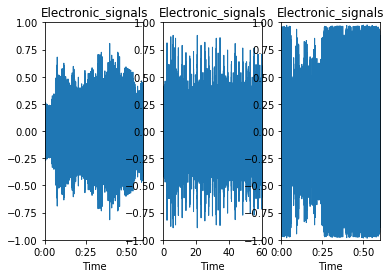

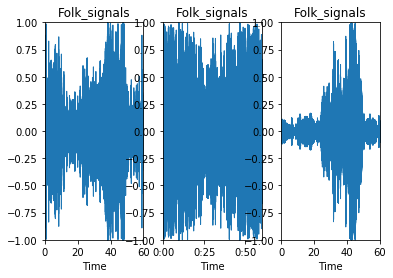

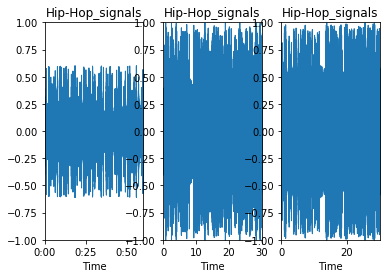

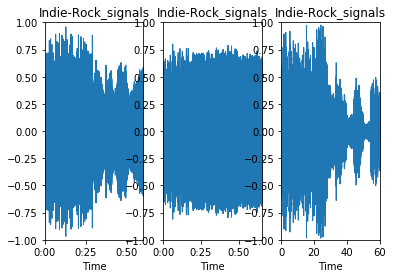

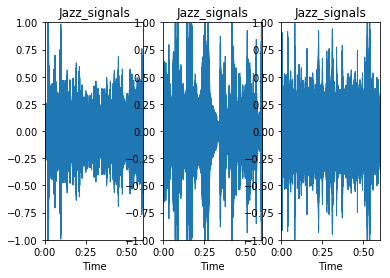

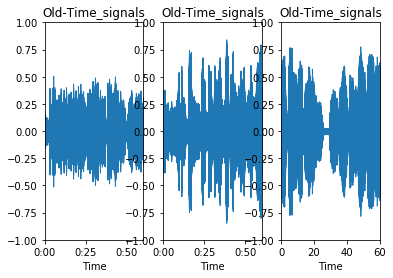

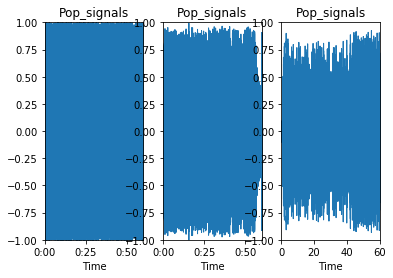

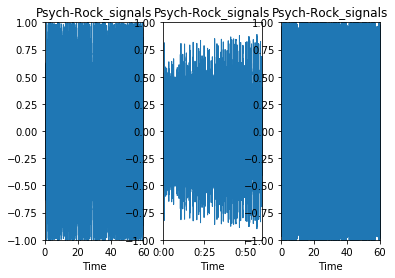

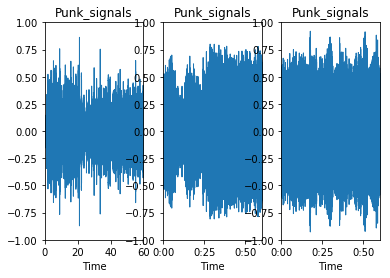

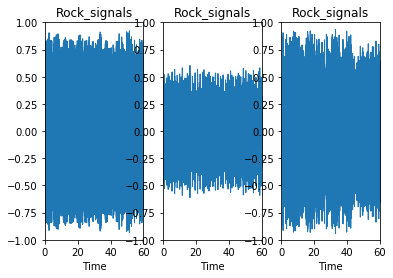

In [49]:
#plot the time series for each song according to the genres

#sig_lengths = []
for genre_signal_name,genre_signals in genre_signals_dict.items(): 
    for i, sig_amp in enumerate(genre_signals):
        plt.subplot(1, num_of_songs, i+1)
#        sig_lengths.append(len(sig_amp))
        waveplot(sig_amp)
        plt.ylim(-1, 1)
        plt.title(genre_signal_name)
    plt.figure()
        
    

In [50]:
song_num = 0
tot_num_of_songs = cumulative_sum[-1]
indiv_song_path= []
for genre_path_name,genre_paths in paths_dict.items(): 
    song_num=song_num+1
    indiv_song_path.append(genre_paths)
  

indiv_song_path_list = np.array(indiv_song_path).reshape(tot_num_of_songs,)

In [51]:
indiv_song_path_list


array(['/Users/chibmac/Documents/fma_small/Electronic/100538.mp3',
       '/Users/chibmac/Documents/fma_small/Electronic/43206.mp3',
       '/Users/chibmac/Documents/fma_small/Electronic/43199.mp3', ...,
       '/Users/chibmac/Documents/fma_small/Rock/693.mp3',
       '/Users/chibmac/Documents/fma_small/Rock/41813.mp3',
       '/Users/chibmac/Documents/fma_small/Rock/9999.mp3'], dtype=object)

In [52]:
genres = []
for song_num in range(len(indiv_song_path_list)):
    temp = indiv_song_path_list[song_num].split(os.sep)[-2]
    genres.append(temp)
        

In [53]:
le = LabelEncoder()
encoded_genres= le.fit(genres)
encoded_genres

#Label Encoding Mapping
encoder_df= pd.DataFrame(data= {'Genre':genres,
                   'Encoded_Genre':le.transform(genres)})
encoder_df.head()

,Encoded_Genre,Genre
0,0,Electronic
1,0,Electronic
2,0,Electronic
3,0,Electronic
4,0,Electronic


In [54]:
print("I AM HERE")

I AM HERE


In [55]:
%%time
tot_num_of_songs = cumulative_sum[-1]
final_d = np.zeros((tot_num_of_songs,test_out.shape[1]))
print(final_d.shape)

for song_num in range(len(indiv_song_path_list)):
    try:
        indiv_song_path = indiv_song_path_list[song_num]
        song_signal = librosa.load(indiv_song_path,sr=None)[0]
        curr_song_genre = encoder_df['Encoded_Genre'][song_num]
        final_d[song_num]= complete_extract_features(song_signal,num_of_sections,num_of_mfcc,curr_song_genre)
    except IOError as exc:
        print("Unable to locate folder")
    


            

(4000, 313)
Unable to locate folder
CPU times: user 1h 29min 12s, sys: 7min 37s, total: 1h 36min 50s
Wall time: 13min 57s


In [56]:
final_d.shape

(4000, 313)

In [57]:
print("I AM HERE")

I AM HERE


In [68]:
arb = 0
temp=list(range(arb,test_out.shape[1]+1+arb))
temp.pop(len(temp)-2)
spe_col=np.array(temp)

In [69]:

complete_df = pd.DataFrame(data=final_d.T,index =range(final_d.shape[1]))
complete_df = complete_df.T

complete_df.head()

,0,1,2,3,4,5,6,7,8,9,...,303,304,305,306,307,308,309,310,311,312
0,-598.502223,34.538343,31.450577,26.824293,21.324431,15.680680,10.545881,6.381493,3.395057,1.540524,...,30.572326,13.456041,-3.584737,3.695816,1.638312,-4.001102,3.730596,6.045746,16.0,0.0
1,-624.344220,36.460312,29.645908,25.797801,25.323062,24.066167,18.109097,9.111137,3.686064,4.130288,...,-52.692751,15.289605,-2.002571,-1.050571,7.602310,21.567622,-11.722388,6.068680,61.0,0.0
2,-126.670270,121.278084,-1.315677,57.047138,18.942589,8.837271,11.700953,28.857965,12.259997,-6.074663,...,17.088584,16.201986,23.243137,21.209535,18.265864,-9.879676,1.323904,10.194635,18.0,0.0
3,-504.542082,42.664128,25.073756,21.809126,15.860772,11.215133,14.144023,11.002758,1.731072,-5.750739,...,20.705632,11.047580,-2.716923,3.212331,-4.129512,0.426485,-9.298046,7.624213,8.0,0.0
4,-507.928549,34.801138,16.620080,-1.298408,-10.021990,-8.144539,-1.163011,4.069320,4.669979,2.684772,...,11.624293,28.758630,-2.184666,-7.635843,-16.516018,7.202388,-8.020235,-1.084436,87.0,0.0


In [70]:
complete_df.shape

(4000, 313)

In [71]:
encoder_df.head()

,Encoded_Genre,Genre
0,0,Electronic
1,0,Electronic
2,0,Electronic
3,0,Electronic
4,0,Electronic


In [75]:
encoder_df.shape

(4000, 2)

In [76]:
final_df = pd.concat([complete_df,encoder_df],axis =1)

In [77]:
final_df.shape

(4000, 315)

In [78]:
final_df = pd.concat([complete_df,encoder_df],axis =1)

final_df = final_df.iloc[:,spe_col]
final_df.head()


,0,1,2,3,4,5,6,7,8,9,...,303,304,305,306,307,308,309,310,311,Encoded_Genre
0,-598.502223,34.538343,31.450577,26.824293,21.324431,15.680680,10.545881,6.381493,3.395057,1.540524,...,30.572326,13.456041,-3.584737,3.695816,1.638312,-4.001102,3.730596,6.045746,16.0,0
1,-624.344220,36.460312,29.645908,25.797801,25.323062,24.066167,18.109097,9.111137,3.686064,4.130288,...,-52.692751,15.289605,-2.002571,-1.050571,7.602310,21.567622,-11.722388,6.068680,61.0,0
2,-126.670270,121.278084,-1.315677,57.047138,18.942589,8.837271,11.700953,28.857965,12.259997,-6.074663,...,17.088584,16.201986,23.243137,21.209535,18.265864,-9.879676,1.323904,10.194635,18.0,0
3,-504.542082,42.664128,25.073756,21.809126,15.860772,11.215133,14.144023,11.002758,1.731072,-5.750739,...,20.705632,11.047580,-2.716923,3.212331,-4.129512,0.426485,-9.298046,7.624213,8.0,0
4,-507.928549,34.801138,16.620080,-1.298408,-10.021990,-8.144539,-1.163011,4.069320,4.669979,2.684772,...,11.624293,28.758630,-2.184666,-7.635843,-16.516018,7.202388,-8.020235,-1.084436,87.0,0


In [73]:
final_df.to_csv("complete_extract.csv",sep=',')